# **오토인코더와 GAN**

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
try:
    IS_COLAB = True
except Exception:
    IS_COLAB = False
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')
# 공통 모듈 임포트
import numpy as np
import os
# 깔끔한 그래프 출력을 위해
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 ' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, 'binary')
    plt.axis('off')

## 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다:

In [3]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(0)

오토인코더를 만든다.

In [4]:
encoder = keras.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(keras.optimizers.experimental.SGD(1.5), 'mse')

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 5s 6ms/step - loss: 0.3706
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0888
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0694
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1196
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0855
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0363
Epoch 7/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0162
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 9/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 10/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 11/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0054
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 13/20
2/2 [==============================] - 0s 8ms/step - loss: 0.

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


그림 저장 linear_autoencoder_pca_plot


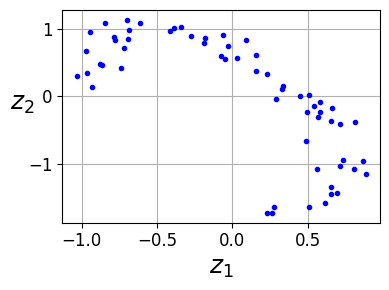

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## 적층 오토인코더

### 케라스를 사용하여 적층 오토인코더 구현하기

MNIST 데이터셋을 사용한다:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,), (10000, 28, 28), (10000,))

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.math.round(y_true), tf.math.round(y_pred))

In [11]:
stacked_encoder = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, 'selu'),
    keras.layers.Dense(30, 'selu'),
])
stacked_decoder = keras.Sequential([
    keras.layers.Dense(100, 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, 'sigmoid'),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))
history = stacked_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3374 - rounded_accuracy: 0.8880 - val_loss: 0.3191 - val_rounded_accuracy: 0.9100
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3054 - rounded_accuracy: 0.9151 - val_loss: 0.3024 - val_rounded_accuracy: 0.9182
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2987 - rounded_accuracy: 0.9211 - val_loss: 0.2967 - val_rounded_accuracy: 0.9241
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2943 - rounded_accuracy: 0.9253 - val_loss: 0.2945 - val_rounded_accuracy: 0.9243
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2917 - rounded_accuracy: 0.9275 - val_loss: 0.2929 - val_rounded_accuracy: 0.9255
Epoch 6/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2899 - rounded_accuracy: 0.9291 - val_loss: 0.2902 - val_rounded_accuracy: 0.9303
Epoch 7/20
1719/1719 [==================

### 재구성 시각화

이 함수는 오토인코더를 사용해 몇 개의 테스트 이미지를 처리한다. 그런 다음 원본 이미지와 재구성 이미지를 그린다:

In [13]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 69ms/step
그림 저장 reconstruction_plot


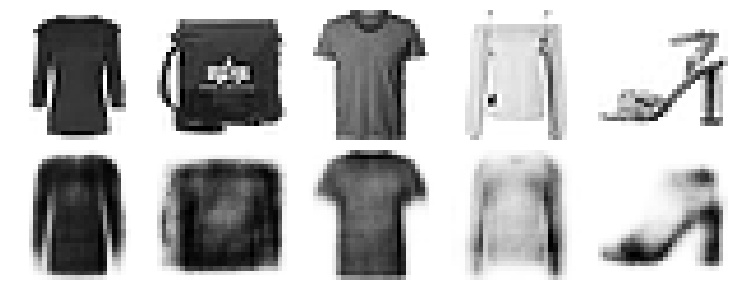

In [14]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

### 패션 MNIST 데이터셋 시각화